In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import nibabel as nib
import proplot as pplt
import matplotlib.pyplot as plt

import os
import sys
import glob
import pickle
sys.path.append('src')

from aux_utils import list_string_to_list
from sal_utils import plot_sal
from scipy.ndimage import zoom

DATA_DIR   = "./data"
CNN_DIR    = "./result/cnn/"
RESULT_DIR = "./result/"
PLOT_DIR   = "./fig/"
SAL_DIR    = "./result/sal/"

# Set display option and color cycle for pandas and proplot
pd.set_option('display.float_format', '{:,.4f}'.format)
pplt.rc.cycle = '538'

# Extract colors from the cycle for further usage
cycle = pplt.Cycle('538')
COLOR = [c['color'] for c in cycle]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### CT scan segmentation

In [2]:
data_prev = nib.load(os.path.join(DATA_DIR, '80-801-007-V1.nii')).get_fdata()

data_prev = data_prev - data_prev.min()
data_prev = data_prev / data_prev.max()

with open(os.path.join(DATA_DIR, 'seg_80-801-007-V1_613_2_1.pickle'), 'rb') as handle:
    data_seg = pickle.load(handle)

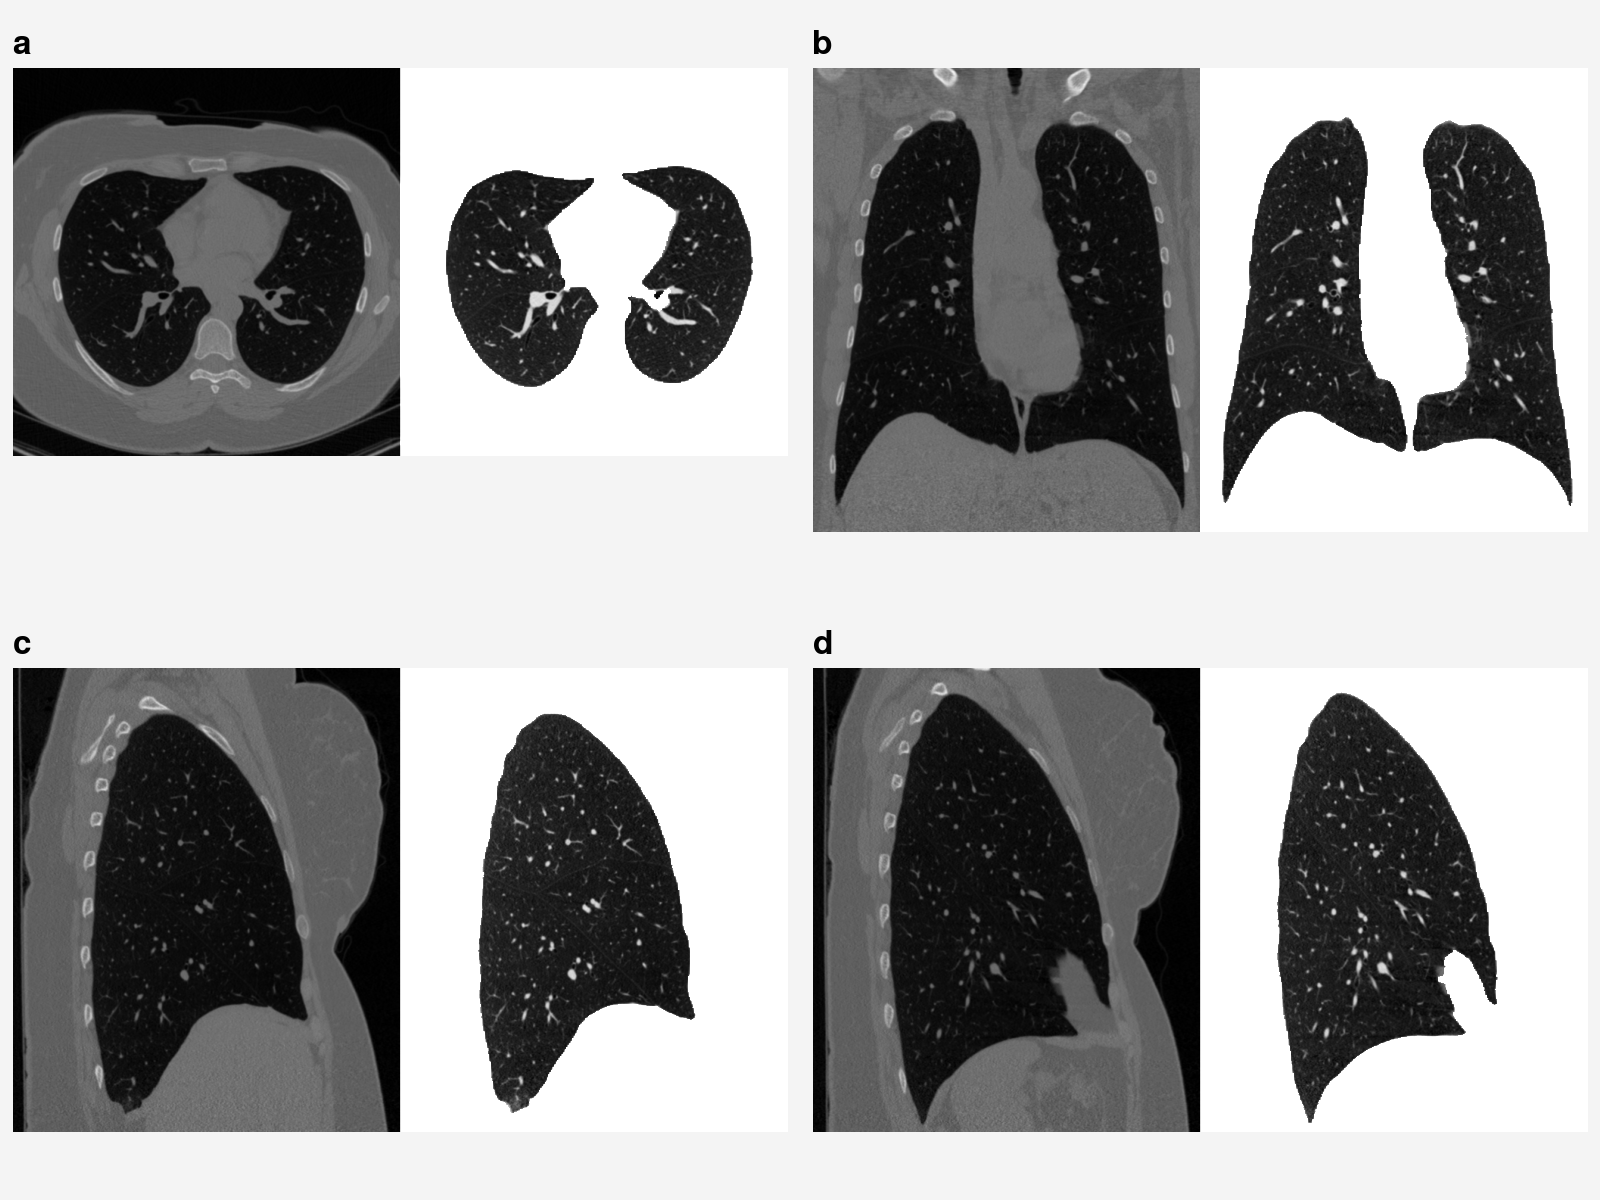

In [6]:
fig, ax = pplt.subplots(nrows=2, ncols=2, figsize=(8, 6), hspace=0.0)

fig1 = np.concatenate((np.rot90(data_prev[..., 290+32]), np.flipud(data_seg[290, ...])), axis=1)
fig2 = np.concatenate((np.rot90(data_prev[:, 256, 32:-21]), np.flipud(data_seg[..., 256, :])), axis=1)
fig3 = np.concatenate((np.rot90(data_prev[128, :, 32:-21]), np.flipud(data_seg[:, :, 128])), axis=1)
fig4 = np.concatenate((np.rot90(data_prev[-128, :, 32:-21]), np.flipud(data_seg[:, :, -128])), axis=1)


vmin = 0.0
vmax = 0.6
cmap = 'gray'
ax[0].imshow(fig1, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1].imshow(fig2, cmap=cmap, vmin=vmin, vmax=vmax)
ax[2].imshow(fig3, cmap=cmap, vmin=vmin, vmax=vmax)
ax[3].imshow(fig4, cmap=cmap, vmin=vmin, vmax=vmax)

for ax_ in ax:
    ax_.axis('off')
    ax_.format(abc=True, abcsize=12)
    
fig.save(os.path.join(PLOT_DIR, 'ct_segmentation.png'), transparent=True, dpi=300)


### Different resolution

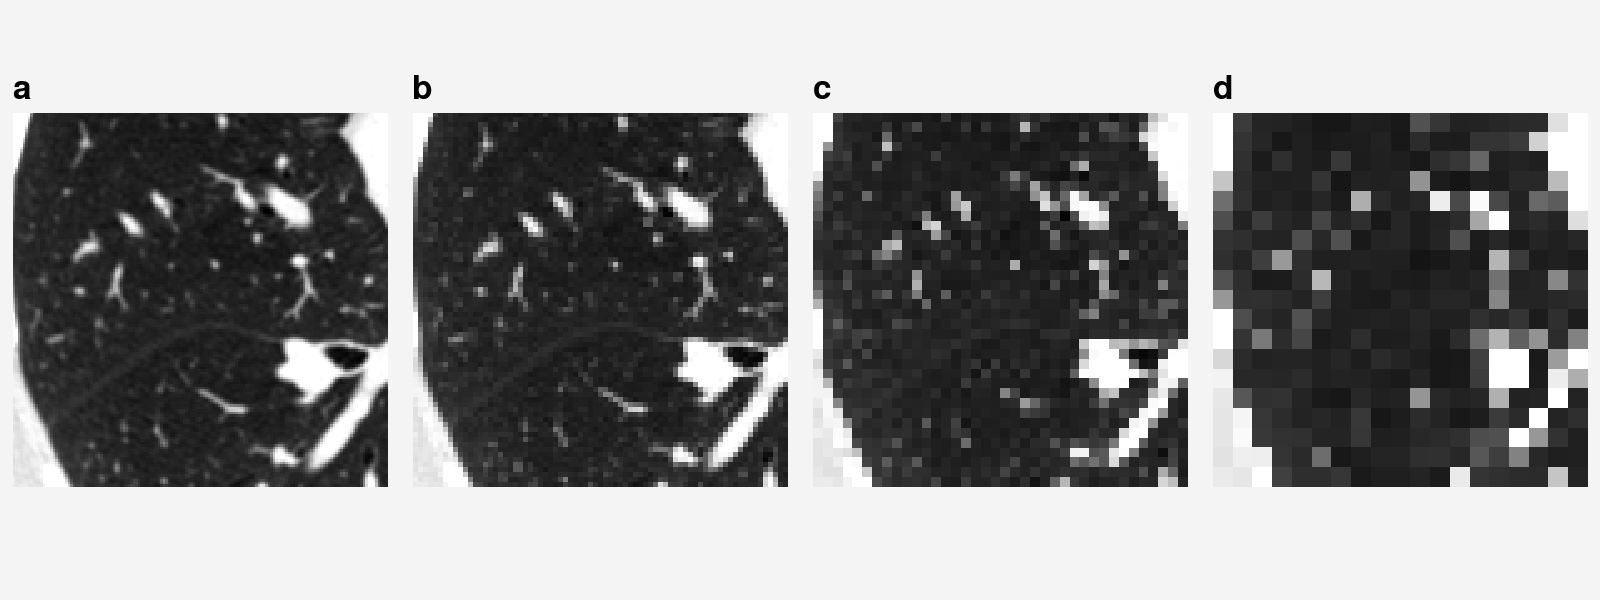

In [5]:
fig, ax = pplt.subplots(nrows=1, ncols=4, figsize=(8, 3), share=False)


fig1 = np.rot90(np.copy(data_prev[60:210, 160:310, 280+32]))
fig2 = zoom(np.copy(fig1), zoom=0.5)
fig3 = zoom(np.copy(fig1), zoom=0.25)
fig4 = zoom(np.copy(fig1), zoom=0.125)

vmin = 0
vmax = 0.25
cmap = 'gray'

ax[0].imshow(fig1, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
ax[1].imshow(fig2, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
ax[2].imshow(fig3, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
ax[3].imshow(fig4, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)

for ax_ in ax:
    ax_.axis('off')
    ax_.format(abc=True, abcsize=12)
    
fig.save(os.path.join(PLOT_DIR, 'ct_diff_res.png'), transparent=True, dpi=300)


### Load results

In [14]:
df_cnn    = pd.read_csv(os.path.join(RESULT_DIR, "result_cnn.csv"))
df_hybrid = pd.read_csv(os.path.join(RESULT_DIR, "result_hybrid.csv"))
df_laa    = pd.read_csv(os.path.join(RESULT_DIR, "result_LAA.csv"))

### CNN results

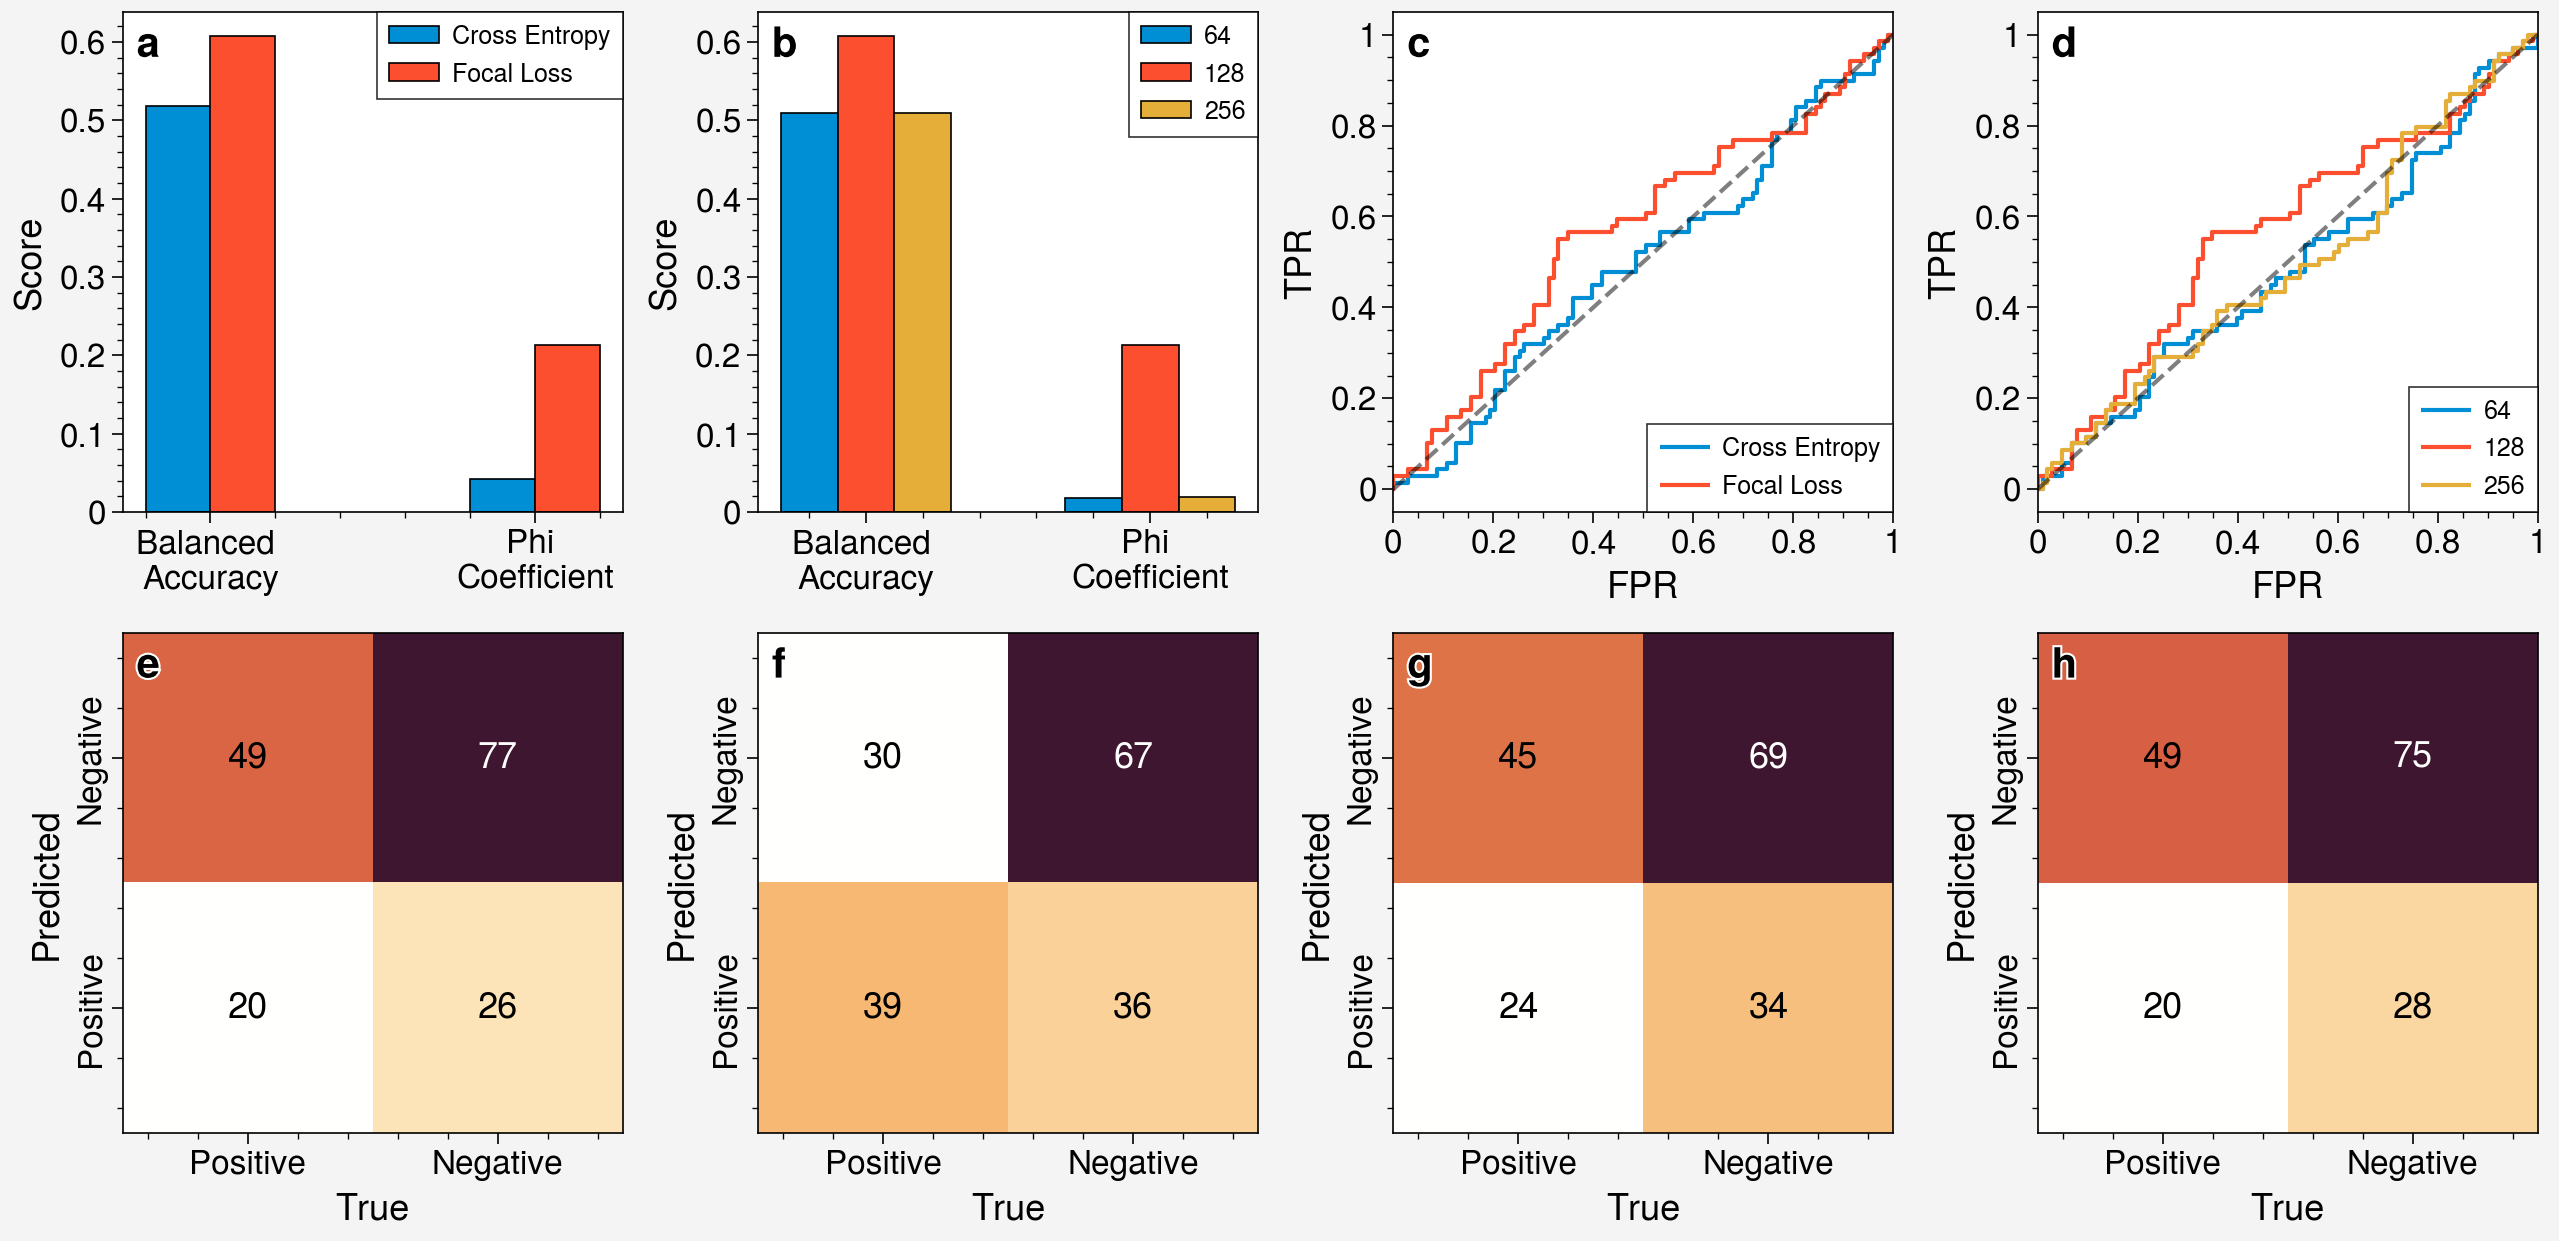

In [8]:
gs = pplt.GridSpec(nrows=2, ncols=4, pad=1)

fig = pplt.figure(span=False, refwidth=2.5, share=False)
ax = []
ax = [fig.subplot(gs[0, i]) for i in range(4)] + [fig.subplot(gs[1, i]) for i in range(4)]

d1 = df_cnn[(df_cnn["Res"] == 0.25 ) & (df_cnn["Gamma"] == 0) & (df_cnn["Lr"] == 0.001) & (df_cnn["Group"] == "Test")]
d2 = df_cnn[(df_cnn["Res"] == 0.25 ) & (df_cnn["Gamma"] == 2) & (df_cnn["Lr"] == 0.001) & (df_cnn["Group"] == "Test")]
d3 = df_cnn[(df_cnn["Res"] == 0.125 ) & (df_cnn["Gamma"] == 2) & (df_cnn["Lr"] == 0.001) & (df_cnn["Group"] == "Test")]
d4 = df_cnn[(df_cnn["Res"] == 0.5 ) & (df_cnn["Gamma"] == 2) & (df_cnn["Lr"] == 0.001) & (df_cnn["Group"] == "Test")]


ax[0].bar(np.arange(2)-0.1, [d1["Balanced Accuracy"],  d1["Phi Coefficient"]], width=.2, label="Cross Entropy", edgecolor="k")
ax[0].bar(np.arange(2)+0.1, [d2["Balanced Accuracy"],  d2["Phi Coefficient"]], width=.2, label="Focal Loss", edgecolor="k")

ax[1].bar(np.arange(2)-0.2, [d3["Balanced Accuracy"],  d3["Phi Coefficient"]], width=.2, label="64", edgecolor="k")
ax[1].bar(np.arange(2)-0.0, [d2["Balanced Accuracy"],  d2["Phi Coefficient"]], width=.2, label="128", edgecolor="k")
ax[1].bar(np.arange(2)+0.2, [d4["Balanced Accuracy"],  d4["Phi Coefficient"]], width=.2, label="256", edgecolor="k")


ax[2].plot(list_string_to_list(d1['FPR'].values), list_string_to_list(d1['TPR'].values), label="Cross Entropy")
ax[2].plot(list_string_to_list(d2['FPR'].values), list_string_to_list(d2['TPR'].values), label="Focal Loss")
ax[2].plot([0, 1], [0, 1], "k--", alpha=0.5)

ax[3].plot(list_string_to_list(d3['FPR'].values), list_string_to_list(d3['TPR'].values), label="64")
ax[3].plot(list_string_to_list(d2['FPR'].values), list_string_to_list(d2['TPR'].values), label="128")
ax[3].plot(list_string_to_list(d4['FPR'].values), list_string_to_list(d4['TPR'].values), label="256")
ax[3].plot([0, 1], [0, 1], "k--", alpha=0.5)


num_classes = 2
class_names = ["Negative", "Positive"]    
tick_marks = np.arange(num_classes)

for i, result in enumerate([list_string_to_list(d1["Conf"].values).reshape((2,2)), 
                           list_string_to_list(d2["Conf"].values).reshape((2,2)), 
                           list_string_to_list(d3["Conf"].values).reshape((2,2)), 
                           list_string_to_list(d4["Conf"].values).reshape((2,2))]):
    result = np.fliplr(result.T)
    thresh = result.max() / 1.5
    
    ax[i+4].imshow(result, interpolation="nearest")
    ax[i+4].grid()
    ax[i+4].set_xticks(tick_marks)
    ax[i+4].set_yticks(tick_marks)
    ax[i+4].set_xticklabels(["Positive", "Negative"])
    ax[i+4].set_yticklabels(["Negative", "Positive"], rotation=90, va="center")
    ax[i+4].set_xlabel("True")
    ax[i+4].set_ylabel("Predicted")

    for k in range(result.shape[0]):
        for j in range(result.shape[1]):
            ax[i+4].text(j, k, f"{int(result[k, j])}", fontsize=13, ha="center", va="center", color="white" if result[k, j] == 0 or result[k, j] > thresh else "black")


for i in range(2):
    ax[i].legend(ncol=1, loc=1)
    ax[i].set_ylabel("Score")
    ax[i].set_xticks(np.arange(2))
    ax[i].set_xticklabels(["Balanced \nAccuracy", "Phi \nCoefficient"])

for i in range(2, 4):
    ax[i].legend(ncol=1, loc=4)
    ax[i].set_xlabel("FPR")
    ax[i].set_ylabel("TPR")

for i in range(8):
    ax[i].format(abc=True, abcloc="ul", abcsize=15, xticklabelsize=12,
            yticklabelsize=12, xlabelsize=13, ylabelsize=13, grid="off")

fig.save(os.path.join(PLOT_DIR, "cnn_result.png"), transparent=True, dpi=300)

### Hybrid results

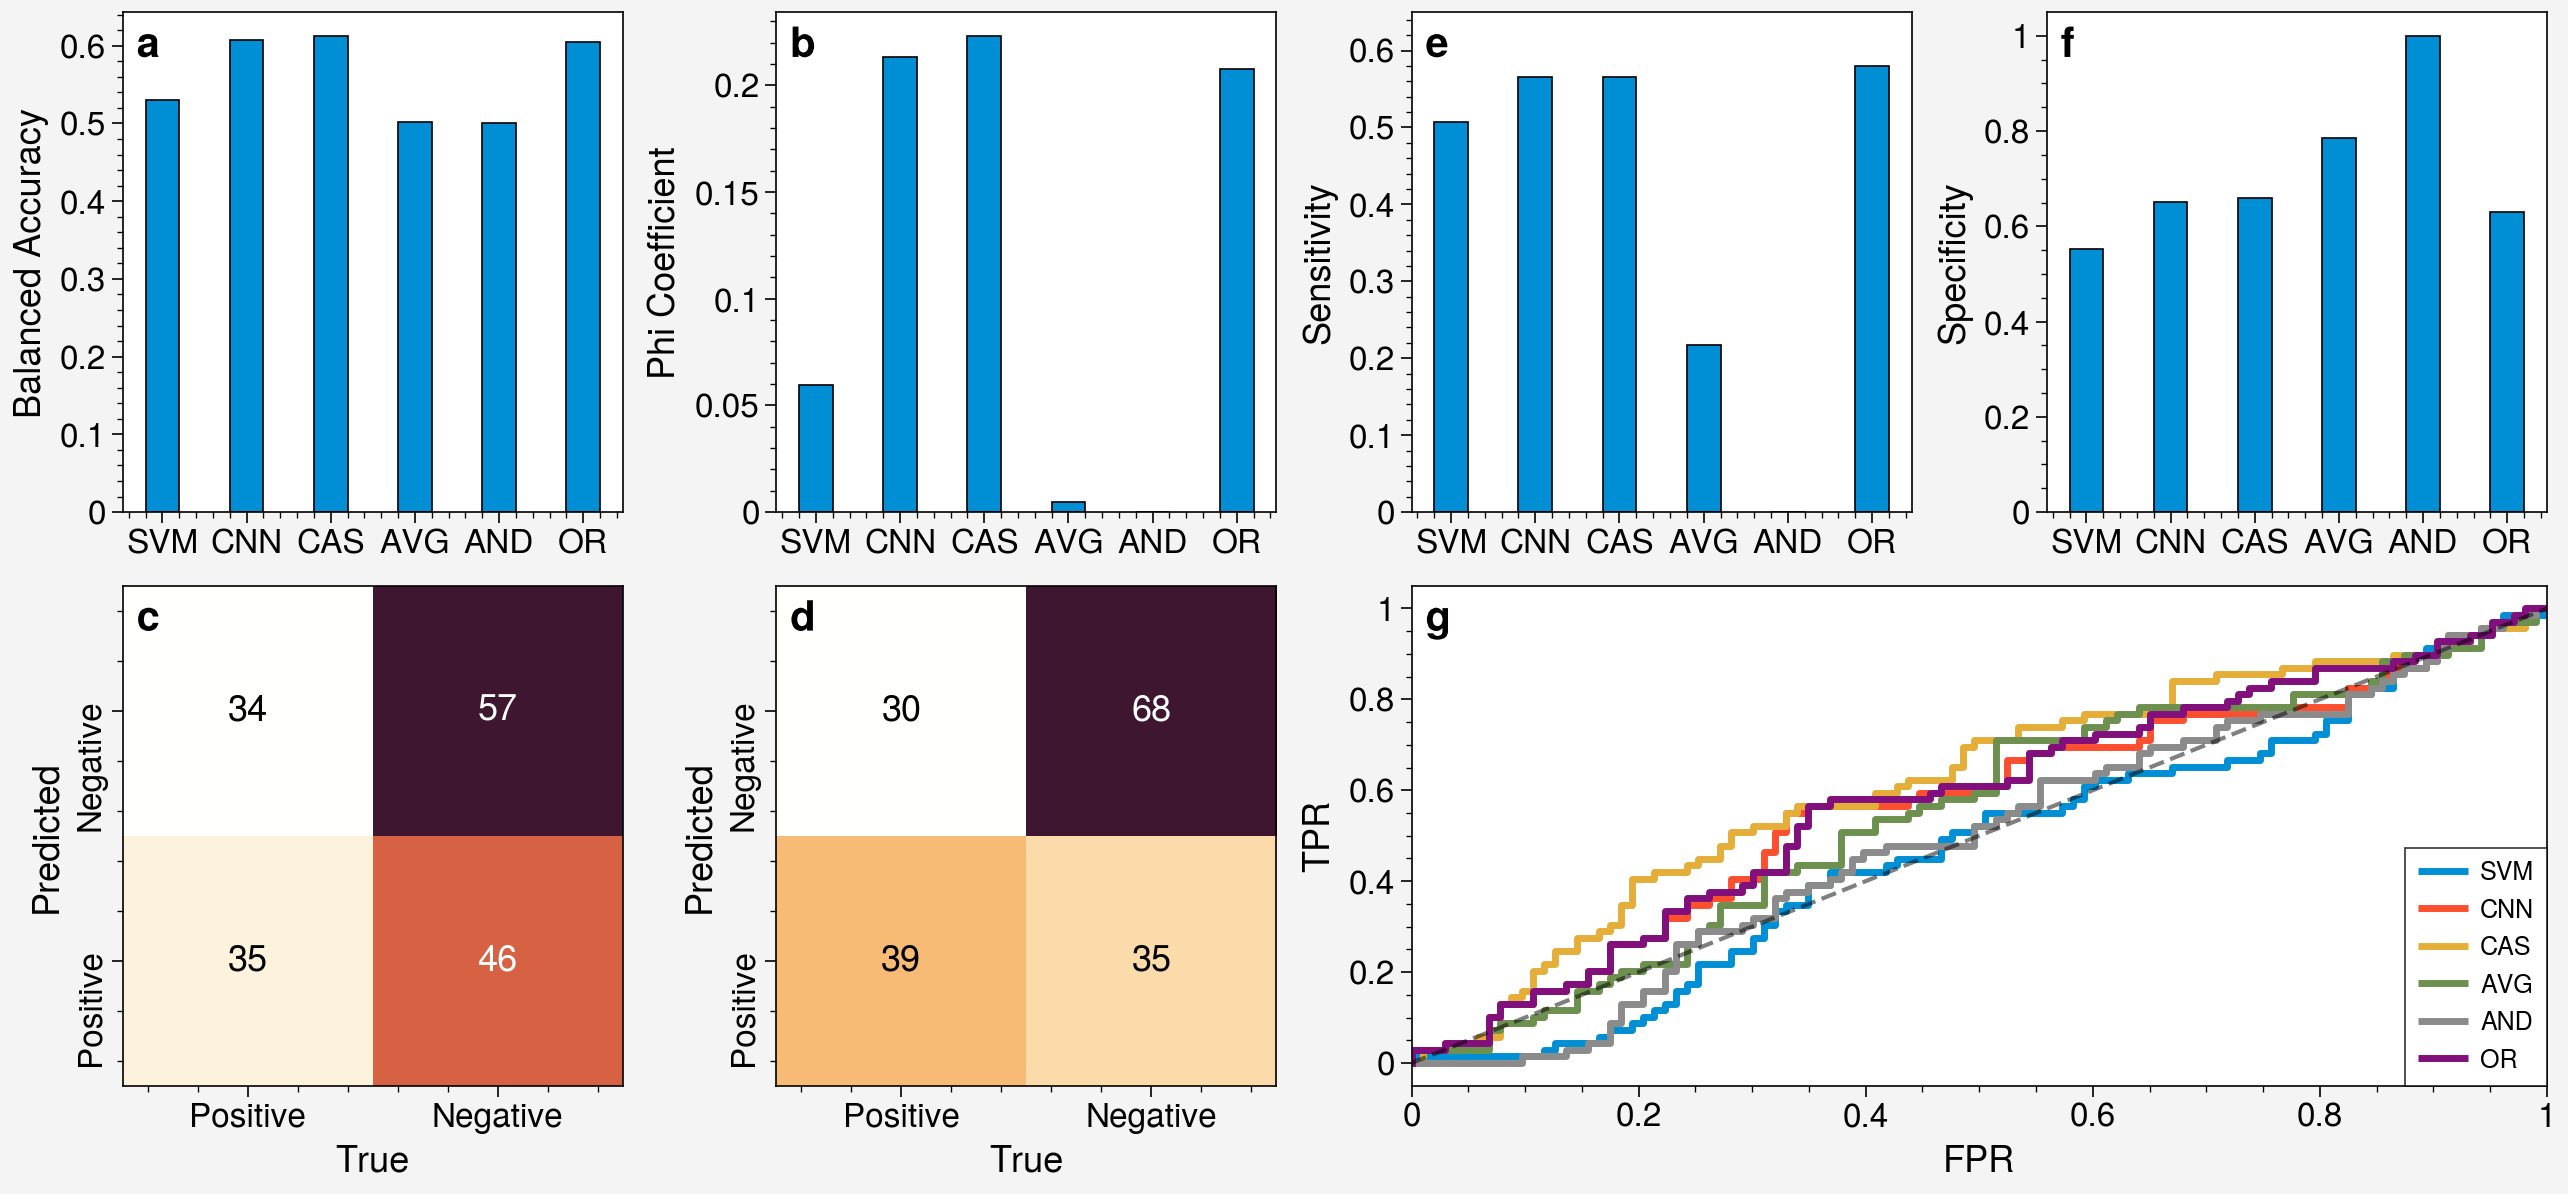

In [11]:
gs = pplt.GridSpec(nrows=2, ncols=4, pad=1)

fig = pplt.figure(span=False, refwidth=2.5, share=False)
ax1 = fig.subplot(gs[0, 0])
ax2 = fig.subplot(gs[0, 1])
ax4 = fig.subplot(gs[1, 0])
ax5 = fig.subplot(gs[1, 1])

ax6 = fig.subplot(gs[0, 2])
ax7 = fig.subplot(gs[0, 3])

ax3 = fig.subplot(gs[1, 2:])

d1 = df_hybrid[df_hybrid["Group"] == "SVM"]
d2 = df_cnn[(df_cnn["Res"] == 0.25 ) & (df_cnn["Gamma"] == 2) & (df_cnn["Lr"] == 0.001) & (df_cnn["Group"] == "Test")]
d3 = df_hybrid[df_hybrid["Group"] == "CAS"]
d4 = df_hybrid[df_hybrid["Group"] == "AVG"]
d5 = df_hybrid[df_hybrid["Group"] == "AND"]
d6 = df_hybrid[df_hybrid["Group"] == "OR"]

ax1.bar(np.arange(6), [d1['Balanced Accuracy'],
                       d2['Balanced Accuracy'],
                       d3['Balanced Accuracy'],
                       d4['Balanced Accuracy'],
                       d5['Balanced Accuracy'],
                       d6['Balanced Accuracy']], width=.4, edgecolor='k')
ax2.bar(np.arange(6), [d1['Phi Coefficient'],
                       d2['Phi Coefficient'],
                       d3['Phi Coefficient'],
                       d4['Phi Coefficient'],
                       d5['Phi Coefficient'],
                       d6['Phi Coefficient']], width=.4, edgecolor='k')
ax6.bar(np.arange(6), [d1['Sensitivity'],
                       d2['Sensitivity'],
                       d3['Sensitivity'],
                       d4['Sensitivity'],
                       d5['Sensitivity'],
                       d6['Sensitivity']], width=.4, edgecolor='k')
ax7.bar(np.arange(6), [d1['Specificity'],
                       d2['Specificity'],
                       d3['Specificity'],
                       d4['Specificity'],
                       d5['Specificity'],
                       d6['Specificity']], width=.4, edgecolor='k')


ax3.plot(list_string_to_list(d1['FPR'].values), list_string_to_list(d1['TPR'].values), label='SVM', lw=2.5)
ax3.plot(list_string_to_list(d2['FPR'].values), list_string_to_list(d2['TPR'].values), label='CNN', lw=2.5)
ax3.plot(list_string_to_list(d3['FPR'].values), list_string_to_list(d3['TPR'].values), label='CAS', lw=2.5)
ax3.plot(list_string_to_list(d4['FPR'].values), list_string_to_list(d4['TPR'].values), label='AVG', lw=2.5)
ax3.plot(list_string_to_list(d5['FPR'].values), list_string_to_list(d5['TPR'].values), label='AND', lw=2.5)
ax3.plot(list_string_to_list(d6['FPR'].values), list_string_to_list(d6['TPR'].values), label='OR', lw=2.5)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)


cf = list_string_to_list(d1["Conf"].values).reshape((2,2))
cf = np.fliplr(cf.T)

num_classes = 2
class_names = ['Negative', 'Positive']                

ax4.imshow(cf, interpolation='nearest')

tick_marks = np.arange(num_classes)
classNames = class_names
   
thresh = cf.max() / 1.5
for i in range(cf.shape[0]):
    for j in range(cf.shape[1]):
        ax4.text(j, i, f"{int(cf[i, j])}", fontsize=13,
                ha="center", va="center",
                color="white" if  cf[i, j] == 0 or cf[i, j] > thresh else "black")

ax4.grid()
ax4.set_xticks([0, 1])
ax4.set_yticks([0, 1])
ax4.set_xticklabels(['Positive', 'Negative'])
ax4.set_yticklabels(['Negative', 'Positive'], rotation=90)
ax4.set_xlabel('True')
ax4.set_ylabel('Predicted')

cf = list_string_to_list(d3["Conf"].values).reshape((2,2))
cf = np.fliplr(cf.T)

num_classes = 2
class_names = ['Negative', 'Positive']                

ax5.imshow(cf, interpolation='nearest')

tick_marks = np.arange(num_classes)
classNames = class_names
   
thresh = cf.max() / 1.5
for i in range(cf.shape[0]):
    for j in range(cf.shape[1]):
        ax5.text(j, i, f"{int(cf[i, j])}", fontsize=13,
                ha="center", va="center",
                color="white" if  cf[i, j] == 0 or cf[i, j] > thresh else "black")

ax5.grid()
ax5.set_xticks([0, 1])
ax5.set_yticks([0, 1])
ax5.set_xticklabels(['Positive', 'Negative'])
ax5.set_yticklabels(['Negative', 'Positive'], rotation=90)
ax5.set_xlabel('True')
ax5.set_ylabel('Predicted')

metrics = ['Balanced Accuracy', 'Phi Coefficient', 'Sensitivity', 'Specificity']
for i, ax in enumerate([ax1, ax2, ax6, ax7]):
    ax.set_ylabel(metrics[i])
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(['SVM', 'CNN', 'CAS', 'AVG', 'AND', 'OR'])

ax3.set_xlabel('FPR')
ax3.set_ylabel('TPR')
ax3.legend(loc=4, ncol=1, fontsize=12)

ax6.set_ylim([0.0, 0.65])

for ax in [ax1, ax2, ax3, ax4, ax6, ax7, ax5]:
    ax.format(abc=True, abcloc='ul', abcsize=15, xticklabelsize=12,
            yticklabelsize=12, xlabelsize=13, ylabelsize=13, grid="off")

fig.save(os.path.join(PLOT_DIR, "result_128.png"), transparent=True, dpi=300)


### Variable importance

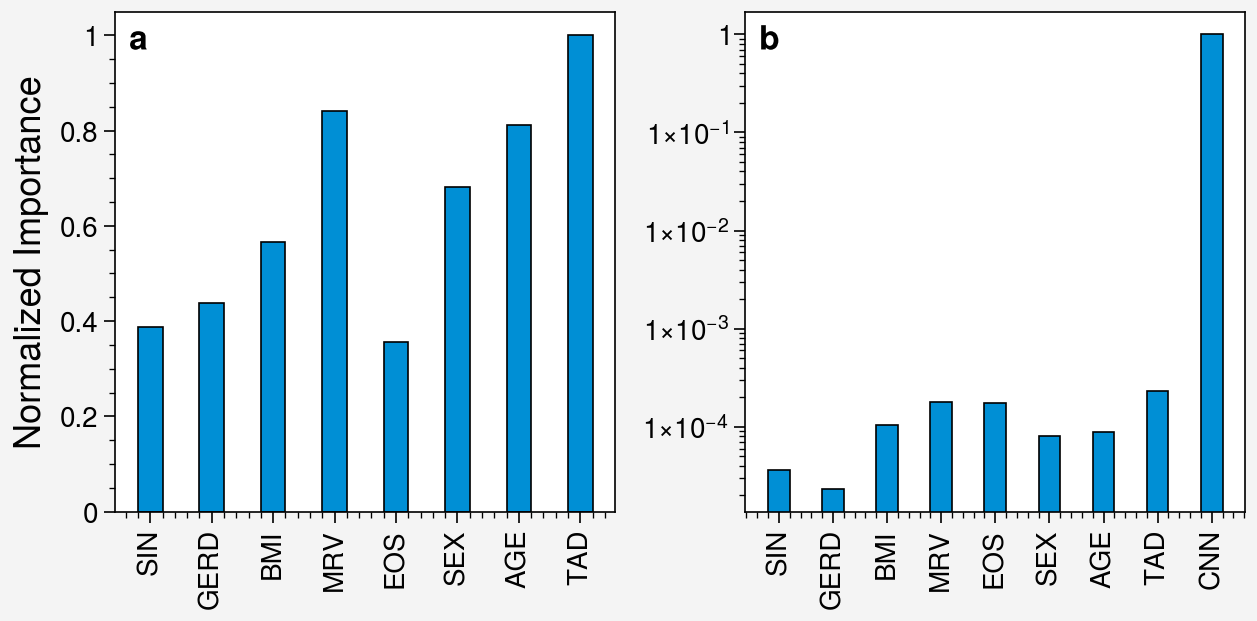

In [12]:
d1 = df_hybrid[df_hybrid["Group"] == "SVM"]
d2 = df_hybrid[df_hybrid["Group"] == "CAS"]

imp_bio = np.array([list_string_to_list(d1[f"coef {i}"].values) for i in range(5)])
imp_bio = np.abs(imp_bio.squeeze()).mean(axis=0)

imp_cas = np.array([list_string_to_list(d2[f"coef {i}"].values) for i in range(5)])
imp_cas = np.abs(imp_cas.squeeze()).mean(axis=0)


gs = pplt.GridSpec(nrows=1, ncols=2, pad=1)

fig = pplt.figure(span=False, refwidth=2.5, sharex=False, sharey=False)
ax1 = fig.subplot(gs[0, 0])
ax2 = fig.subplot(gs[0, 1])

ax1.bar(np.arange(8), imp_bio / imp_bio.max(), width=.4, edgecolor='k')
ax2.bar(np.arange(9), imp_cas / imp_cas.max(), width=.4, edgecolor='k')


ax1.set_ylabel('Normalized Importance')
ax1.set_xticks(np.arange(8))
ax1.set_xticklabels(['SIN', 'GERD', 'BMI', 'MRV', 'EOS', 'SEX', 'AGE', 'TAD'], rotation=90)

ax2.set_xticks(np.arange(9))
ax2.set_xticklabels(['SIN', 'GERD', 'BMI', 'MRV', 'EOS', 'SEX', 'AGE', 'TAD', 'CNN'], rotation=90)

ax1.format(abc=True, abcloc='ul', abcsize=12, xticklabelsize=10,
            yticklabelsize=10, xlabelsize=13, ylabelsize=13, grid='off')
ax2.format(abc=True, abcloc='ul', abcsize=12, xticklabelsize=10,
            yticklabelsize=10, xlabelsize=13, ylabelsize=13, grid='off', yformatter='sci', yscale='log')


fig.save(os.path.join(PLOT_DIR, 'importance_128.png'), transparent=True, dpi=300)


### With and without LAA

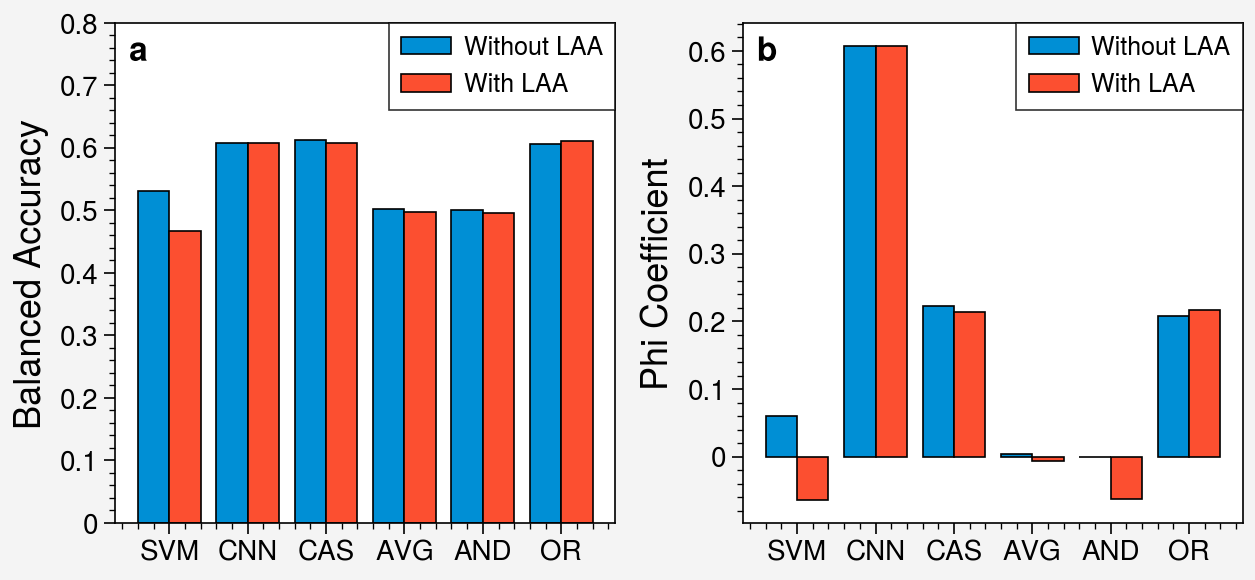

In [15]:
d1 = df_hybrid
d2 = df_laa

d3 = df_cnn[(df_cnn["Res"] == 0.25 ) & (df_cnn["Gamma"] == 2) & (df_cnn["Lr"] == 0.001) & (df_cnn["Group"] == "Test")]

gs = pplt.GridSpec(nrows=1, ncols=2, pad=1)

fig = pplt.figure(span=False, refwidth=2.5, share=False)
ax1 = fig.subplot(gs[0, 0])
ax2 = fig.subplot(gs[0, 1])

ax1.bar(np.arange(6)-0.2, [d1[d1["Group"] == "SVM"]['Balanced Accuracy'],
                           d3['Balanced Accuracy'],
                           d1[d1["Group"] == "CAS"]['Balanced Accuracy'],
                           d1[d1["Group"] == "AVG"]['Balanced Accuracy'],
                           d1[d1["Group"] == "AND"]['Balanced Accuracy'],
                           d1[d1["Group"] == "OR"]['Balanced Accuracy']], width=.4, label='Without LAA', edgecolor='k')

ax1.bar(np.arange(6)+0.2, [d2[d2["Group"] == "SVM"]['Balanced Accuracy'],
                           d3['Balanced Accuracy'],
                           d2[d2["Group"] == "CAS"]['Balanced Accuracy'],
                           d2[d2["Group"] == "AVG"]['Balanced Accuracy'],
                           d2[d2["Group"] == "AND"]['Balanced Accuracy'],
                           d2[d2["Group"] == "OR"]['Balanced Accuracy']], width=.4, label='With LAA', edgecolor='k')

ax2.bar(np.arange(6)-0.2, [d1[d1["Group"] == "SVM"]['Phi Coefficient'],
                           d3['Balanced Accuracy'],
                           d1[d1["Group"] == "CAS"]['Phi Coefficient'],
                           d1[d1["Group"] == "AVG"]['Phi Coefficient'],
                           d1[d1["Group"] == "AND"]['Phi Coefficient'],
                           d1[d1["Group"] == "OR"]['Phi Coefficient']], width=.4, label='Without LAA', edgecolor='k')
ax2.bar(np.arange(6)+0.2, [d2[d2["Group"] == "SVM"]['Phi Coefficient'],
                           d3['Balanced Accuracy'],
                           d2[d2["Group"] == "CAS"]['Phi Coefficient'],
                           d2[d2["Group"] == "AVG"]['Phi Coefficient'],
                           d2[d2["Group"] == "AND"]['Phi Coefficient'],
                           d2[d2["Group"] == "OR"]['Phi Coefficient']], width=.4, label='With LAA', edgecolor='k')

ax1.set_ylim([None, 0.7])
metrics = ['Balanced Accuracy', 'Phi Coefficient']
for i, ax in enumerate([ax1, ax2]):
    ax.set_ylabel(metrics[i])
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(['SVM', 'CNN', 'CAS', 'AVG', 'AND', 'OR'])
    ax.legend(loc=1, ncol=1)

for ax in [ax1, ax2]:
    ax.format(abc=True, abcloc='ul', abcsize=12, xticklabelsize=10,
            yticklabelsize=10, xlabelsize=13, ylabelsize=13, grid='off')

ax1.set_ylim([0.0, 0.8])

fig.save(os.path.join(PLOT_DIR, 'result_128_laa.png'), transparent=True, dpi=300)


### Learning curves for different loss functions

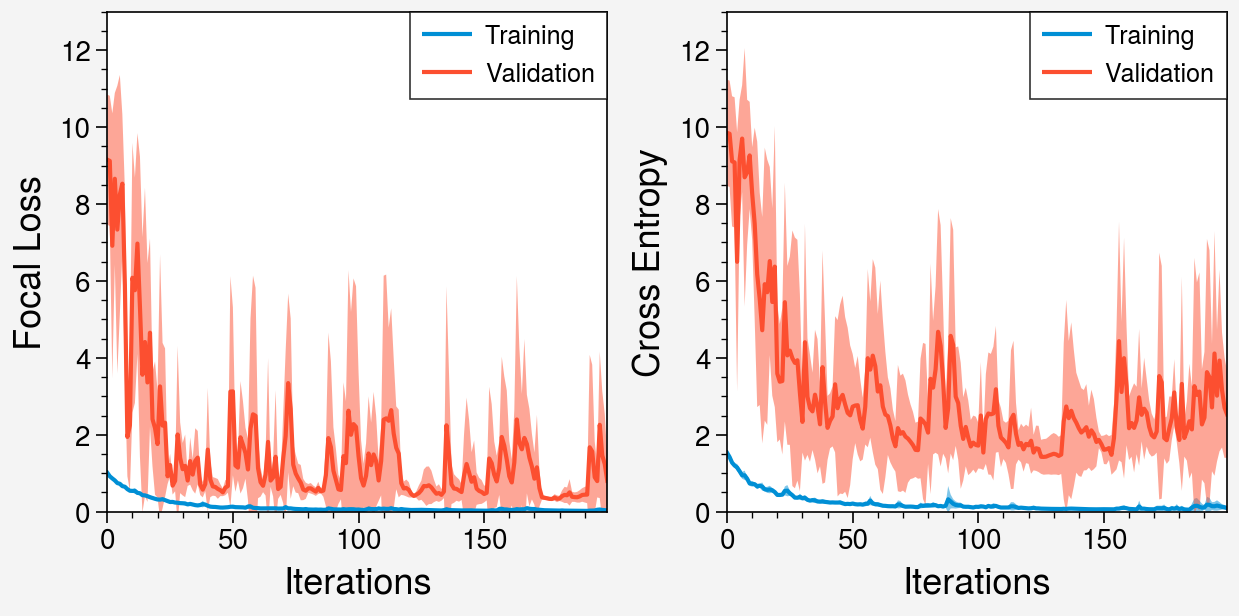

In [18]:
histories=[]
histories_nofocal=[]
res=0.25
gamma=2
lr=0.001
for i in range(5):
    file_path = glob.glob(os.path.join(CNN_DIR, f"z_{res}_g_{gamma}_l_{lr}/z_{res}_f_{i}_g_{gamma}_l_{lr}.pickle"))[0]
    with open(file_path, "rb") as handle:
        y_test, y_pred, y_train, y_pred_train, y_valid, y_pred_valid, hist = [pickle.load(handle) for _ in range(7)]
    histories.append(hist)

res=0.25
gamma=0
lr=0.001
for i in range(5):
    file_path = glob.glob(os.path.join(CNN_DIR, f"z_{res}_g_{gamma}_l_{lr}/z_{res}_f_{i}_g_{gamma}_l_{lr}.pickle"))[0]
    with open(file_path, "rb") as handle:
        y_test, y_pred, y_train, y_pred_train, y_valid, y_pred_valid, hist = [pickle.load(handle) for _ in range(7)]
    histories_nofocal.append(hist)


fig, ax = pplt.subplots(refwidth=2.5, refheight=2.5, ncols=2, share=False)

x = np.arange(200)

hist_train = []
hist_val = []
hist_train_nofocal = []
hist_val_nofocal = []

for i in range(5):
    hist_train.append(histories[i]['loss'])
    hist_val.append(histories[i]['val_loss'])
    hist_train_nofocal.append(histories_nofocal[i]['loss'])
    hist_val_nofocal.append(histories_nofocal[i]['val_loss'])


hist_train = np.array(hist_train)
hist_val = np.array(hist_val)
hist_train_nofocal = np.array(hist_train_nofocal)
hist_val_nofocal = np.array(hist_val_nofocal)


m1 = hist_train.mean(axis=0)
s1 = hist_train.std(axis=0)

m2 = hist_val.mean(axis=0)
s2 = hist_val.std(axis=0)

m3 = hist_train_nofocal.mean(axis=0)
s3 = hist_train_nofocal.std(axis=0)

m4 = hist_val_nofocal.mean(axis=0)
s4 = hist_val_nofocal.std(axis=0)


ax[0].plot(x, m1, label='Training')
ax[0].plot(x, m2, label='Validation')

ax[1].plot(x, m3, label='Training')
ax[1].plot(x, m4, label='Validation')


ax[0].fill_between(x, m1-s1, m1+s1, alpha=0.5)
ax[0].fill_between(x, m2-s2, m2+s2, alpha=0.5)

ax[1].fill_between(x, m3-s3, m3+s3, alpha=0.5)
ax[1].fill_between(x, m4-s4, m4+s4, alpha=0.5)


ax[0].legend(ncol=1)
ax[1].legend(ncol=1)


ax[0].format(ylabel='Focal Loss', xlabel='Iterations', xticklabelsize=10,
          yticklabelsize=10, xlabelsize=13, ylabelsize=13, ylim=[0, 13], grid='off')

ax[1].format(ylabel='Cross Entropy', xlabel='Iterations', xticklabelsize=10,
          yticklabelsize=10, xlabelsize=13, ylabelsize=13, ylim=[0, 13], grid='off')

fig.save(os.path.join(PLOT_DIR, 'diff_loss_losscurve.png'), transparent=True, dpi=300)


### 3D CNN Saliency map

In [22]:
files = sorted(glob.glob(os.path.join(SAL_DIR, '*.pickle')))

# example file
file = files[1]

with open(file, 'rb') as handle:
    x = pickle.load(handle)
    s = pickle.load(handle)

/Users/sj0161/miniconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


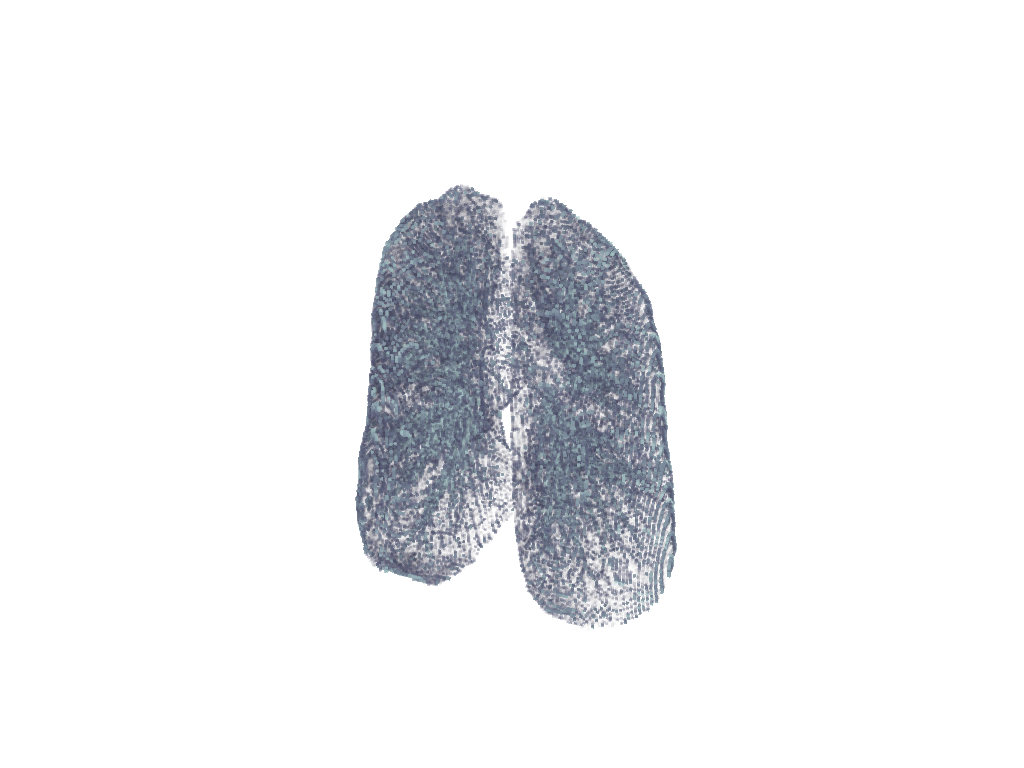

/Users/sj0161/miniconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


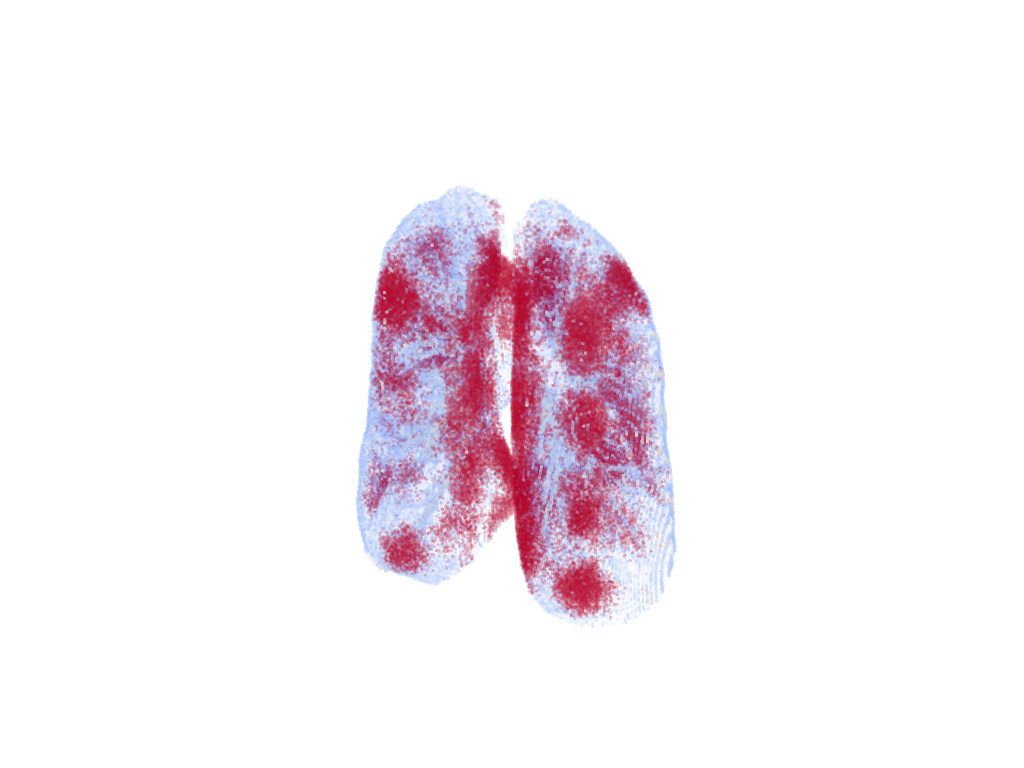

/Users/sj0161/miniconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


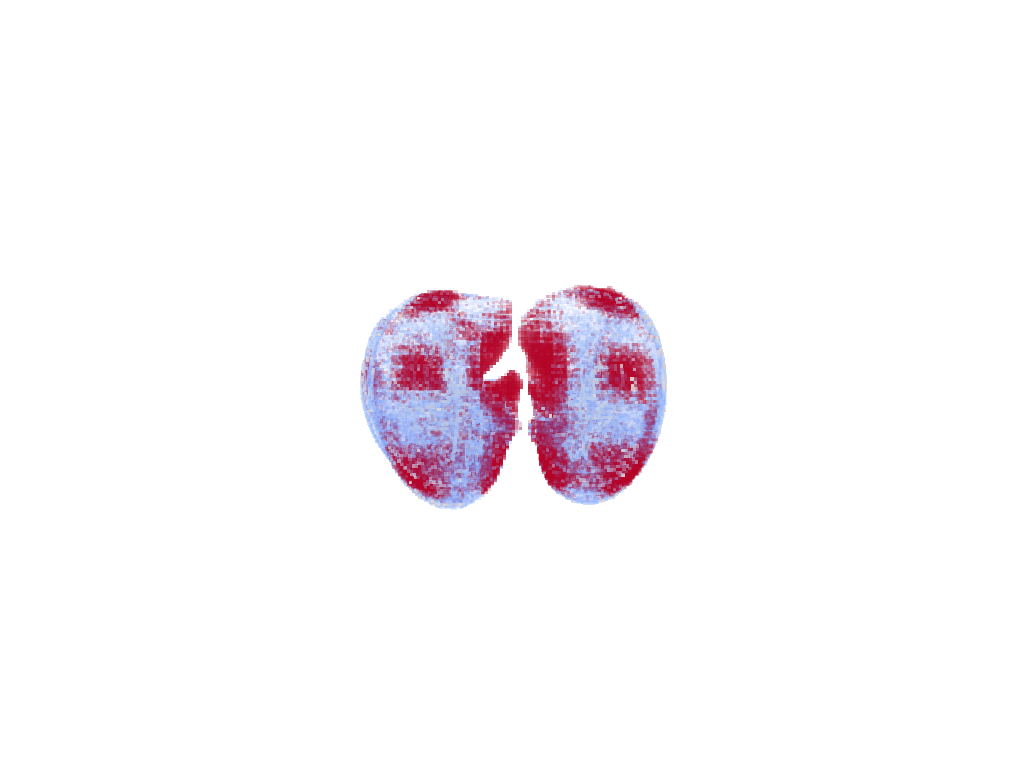

/Users/sj0161/miniconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


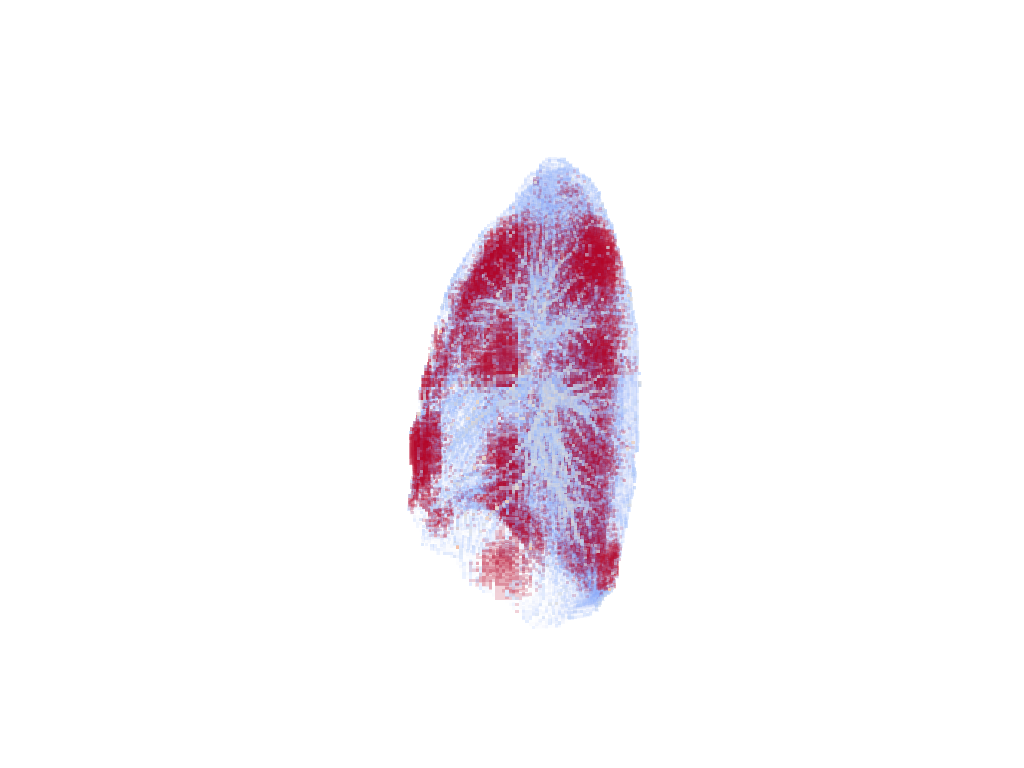

/Users/sj0161/miniconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


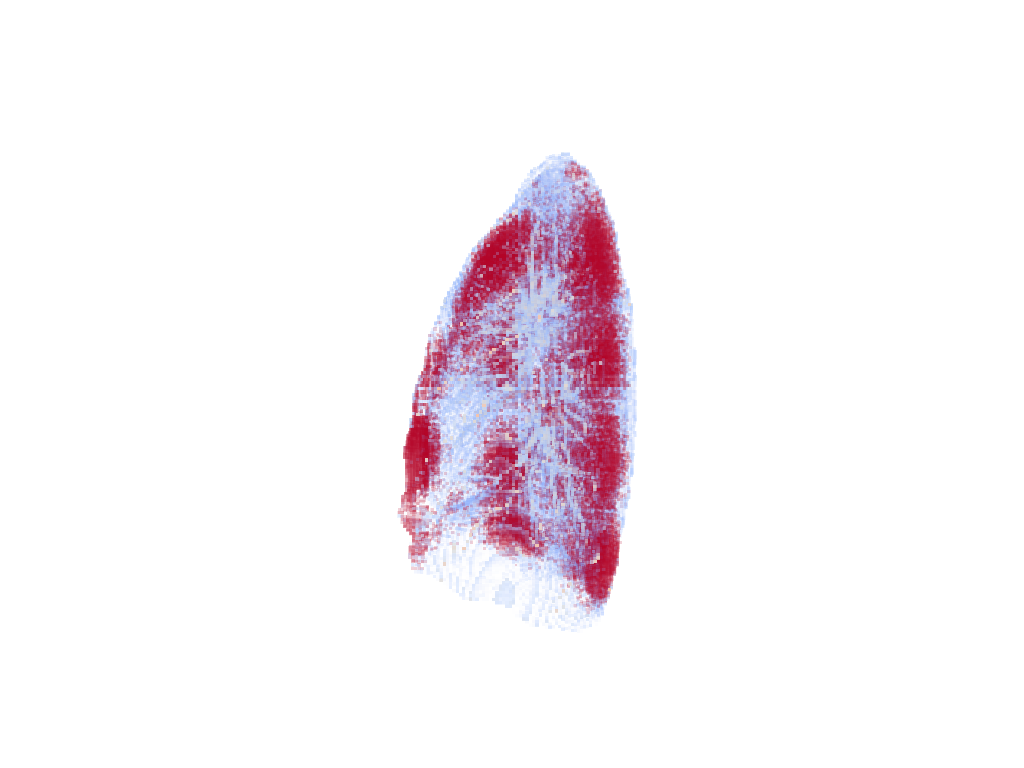

/Users/sj0161/miniconda3/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


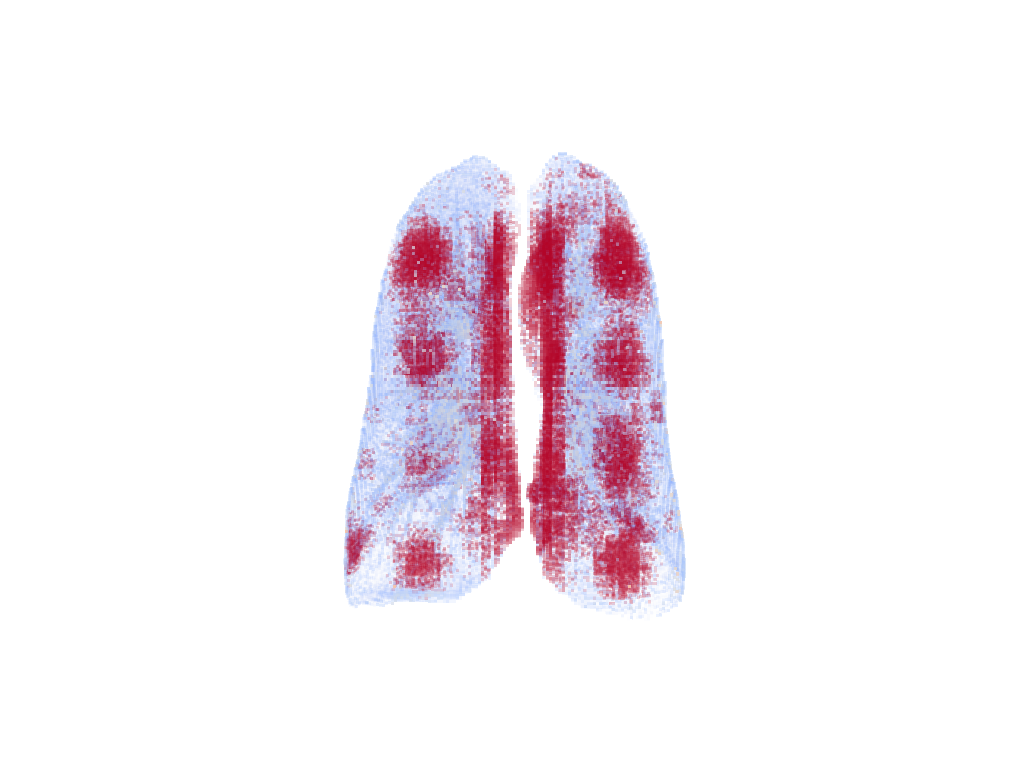

/Users/sj0161/ML/asthma/src/sal_utils.py:101: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  ax.axis('off')


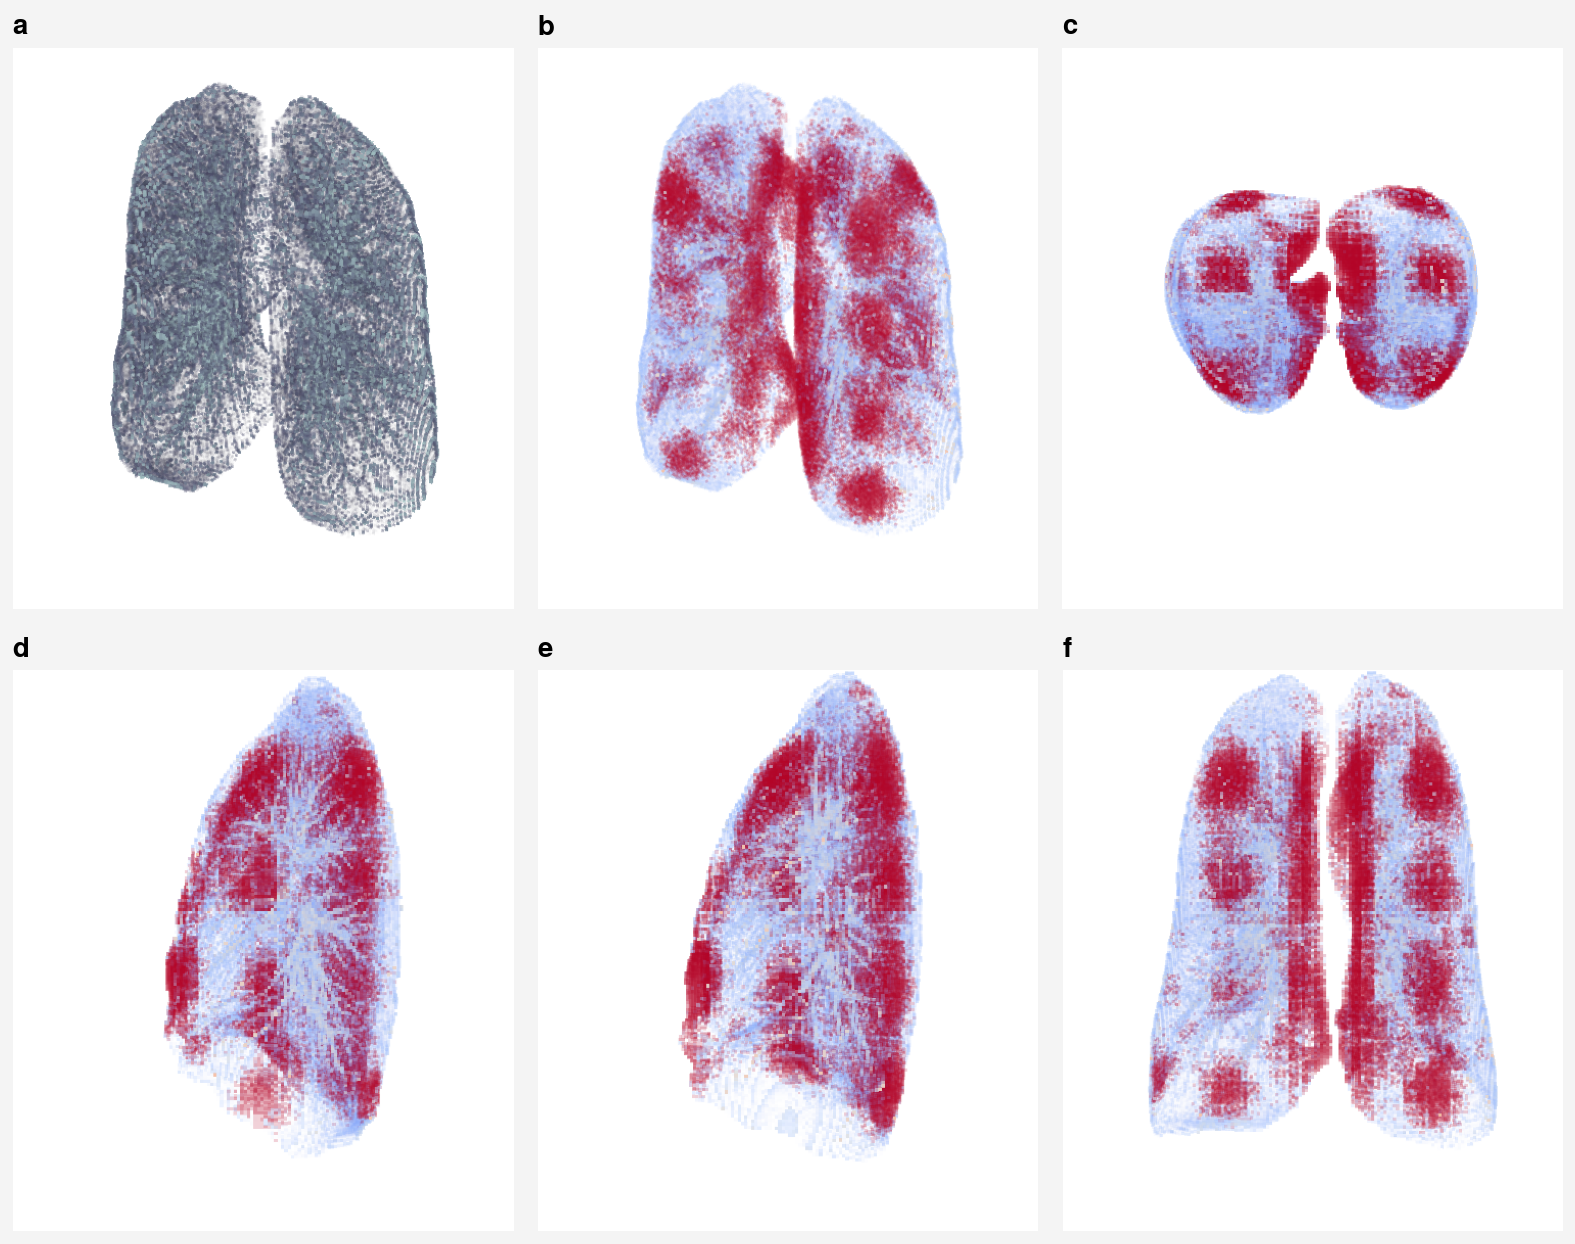

: 

In [26]:
a = plot_sal(PLOT_DIR, file)